<a href="https://colab.research.google.com/github/moarshy/PyTorch_fastai_Projects/blob/main/fastai_imgc_plantpathology_resnet_softlabellig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook softlabelling was implemented to reduce the impact of noisy labels in this [Kaggle competition](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)

References:

[notebooks](https://github.com/Isaac-Flath/kaggle/tree/main/2020-competitions/Plant_Pathology)

[Isaac's Blog](https://isaac-flath.github.io/blog/deep%20learning/2021/01/18/SoftLabeling.html)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install fastai -q --upgrade

In [3]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold
import gc

In [4]:
SEED = 42
set_seed(SEED)
path = Path('/content/drive/MyDrive/colab_notebooks/fastai/plant_pathology/data')

# PseudoLabel generation

In [6]:
df = pd.read_csv(path/'train.csv')

In [7]:
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [8]:
df['label'] = df.iloc[:, 1:].idxmax(1)

In [9]:
#create folds
N_FOLDS = 2
df['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(df.image_id.values, df['label'].values)):
    df.iloc[test_index, -1] = i
    
df['fold'] = df['fold'].astype('int')

In [10]:
df.head(10)

,image_id,healthy,multiple_diseases,rust,scab,label,fold
0,Train_0,0,0,0,1,scab,1
1,Train_1,0,1,0,0,multiple_diseases,1
2,Train_2,1,0,0,0,healthy,0
3,Train_3,0,0,1,0,rust,0
4,Train_4,1,0,0,0,healthy,1
5,Train_5,1,0,0,0,healthy,0
6,Train_6,0,1,0,0,multiple_diseases,1
7,Train_7,0,0,0,1,scab,1
8,Train_8,0,0,0,1,scab,0
9,Train_9,1,0,0,0,healthy,1


In [11]:
def get_dls(df, size, fold, bs):

    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=IndexSplitter(df.loc[df.fold==fold].index),
                       getters=[
                          ColReader('image_id', pref=path/'images', suff='.jpg'),
                          ColReader('label')
                              ],
                       item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(df, bs=bs)

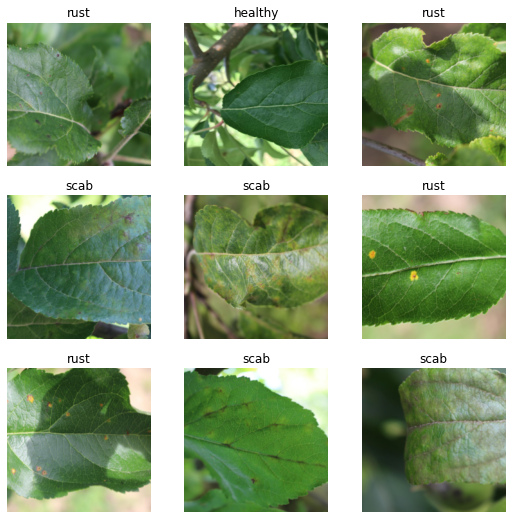

In [12]:
dls = get_dls(df, 224, 0, bs=16)
dls.show_batch()

In [36]:
splits, preds, targs, preds_c,  = [],[],[],[]
items = pd.DataFrame(columns = df.columns)

for i in range(N_FOLDS):

    dls = get_dls(df, 224, i, bs=16)

    learn = cnn_learner(dls, resnet18, metrics=[accuracy,RocAuc()])
    learn.fine_tune(10, reset_opt=True)
    
    # store predictions
    p, t, c = learn.get_preds(ds_idx=1, with_decoded=True)
    preds.append(p); targs.append(t); preds_c.append(c); 
    items = pd.concat([items, dls.valid.items])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.411981,0.713797,0.792536,0.870047,01:20


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.709534,0.499834,0.847420,0.911853,01:22
1,0.588571,0.407983,0.880351,0.935296,01:21
2,0.488128,0.427596,0.884742,0.938118,01:20
3,0.439910,0.349862,0.899012,0.947479,01:22
4,0.363965,0.395973,0.899012,0.941372,01:22
5,0.323230,0.439528,0.886937,0.931641,01:23
6,0.246927,0.387600,0.895719,0.939472,01:22
7,0.206437,0.334387,0.911087,0.945592,01:22
8,0.165572,0.334089,0.911087,0.947704,01:22
9,0.151018,0.311419,0.909989,0.951884,01:22


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.402369,0.608052,0.783516,0.894956,01:21


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.800687,0.441426,0.867033,0.927058,01:22
1,0.584091,0.389376,0.876923,0.943050,01:22
2,0.438013,0.401408,0.881319,0.945486,01:22
3,0.391701,0.393522,0.891209,0.948330,01:23
4,0.337889,0.415939,0.876923,0.951458,01:23
5,0.296600,0.376018,0.892308,0.959475,01:22
6,0.225385,0.323374,0.903297,0.966004,01:23
7,0.172887,0.308598,0.904396,0.964712,01:23
8,0.174614,0.301862,0.908791,0.964535,01:23
9,0.175207,0.335088,0.903297,0.963807,01:22


In [37]:
imgs = L(o for o in items.image_id.values)
y_true = L(o for o in items.label.values) # Labels from dataset
y_targ = L(dls.vocab[o] for o in torch.cat(targs)) # Labels from out predictions
y_pred = L(dls.vocab[o] for o in torch.cat(preds_c)) # predicted labels or "pseudo labels"
p_max = torch.cat(preds).max(dim=1)[0]

In [38]:
assert (y_true == y_targ)

In [39]:
res = pd.DataFrame({'imgs':imgs,'y_true':y_true,'y_pred':y_pred}).set_index('imgs')
print(res.shape)
print(df.shape)
res.sample(5)

(1821, 2)
(1821, 7)


,y_true,y_pred
imgs,,
Train_1594,rust,rust
Train_994,scab,scab
Train_335,healthy,healthy
Train_1356,healthy,healthy
Train_1728,scab,scab


In [40]:
res.to_csv(path/'train_softlabelling.csv')

# Preparing functions and dataframes

In this part, codes were borrowed from this excellent [blog](https://isaac-flath.github.io/blog/deep%20learning/2021/01/18/SoftLabeling.html) by Isaac

In [5]:
#df with actual and pseudolabels (from pseudolabel generation part)
res = pd.read_csv(path/'train_softlabelling.csv')

In [6]:
#one-hot-encode the true_label and pred_labels
res = pd.get_dummies(res,columns=['y_true','y_pred']) 

In [7]:
res.head(3)

,imgs,y_true_healthy,y_true_multiple_diseases,y_true_rust,y_true_scab,y_pred_healthy,y_pred_multiple_diseases,y_pred_rust,y_pred_scab
0,Train_2,1,0,0,0,1,0,0,0
1,Train_3,0,0,1,0,0,0,1,0
2,Train_5,1,0,0,0,0,0,0,1


In [8]:
res['true_label'] = res.iloc[:, 1:5].idxmax(1).apply(lambda x: x.split('true_')[1])

In [9]:
res.head(3)

,imgs,y_true_healthy,y_true_multiple_diseases,y_true_rust,y_true_scab,y_pred_healthy,y_pred_multiple_diseases,y_pred_rust,y_pred_scab,true_label
0,Train_2,1,0,0,0,1,0,0,0,healthy
1,Train_3,0,0,1,0,0,0,1,0,rust
2,Train_5,1,0,0,0,0,0,0,1,healthy


In [10]:
res.rename(columns={'imgs':'image_id'}, inplace=True)

In [11]:
#codes taken from Isaac's blog
class CrossEntropyLossOneHot(nn.Module):
    def __init__(self):
        super(CrossEntropyLossOneHot, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, labels):
        return torch.mean(torch.sum(-labels * self.log_softmax(preds), -1))

def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ.argmax(dim=axis))
    return (pred == targ).float().mean()

In [12]:
# codes taken from Isaac's blog with slight modification
class SoftLabelCB(Callback):
    def __init__(self, df_preds,y_true_weight = 0.7): 
        '''df_preds is a pandas dataframe where index is image paths
             Must have y_true and y_pred one hot encoded columns (ie y_true_0, y_true_1)
          '''
        
        self.y_true_weight = y_true_weight
        self.y_pred_weight = 1 - y_true_weight
        self.df = df_preds

    def before_train(self):
        if type(self.dl.items)==type(pd.DataFrame()): self.idx_list = L(o for o in self.dl.items.index.values)
        if is_listy(self.dl.items): self.imgs_list = L(self.dl.items)      
    
    def before_validate(self):
        if type(self.dl.items)==type(pd.DataFrame()): self.idx_list = L(o for o in self.dl.items.index.values)
        if is_listy(self.dl.items): self.imgs_list = L(self.dl.items)       
    
    def before_batch(self):
        # get the images' names for the current batch
        idx = self.idx_list[self.dl._DataLoader__idxs[self.iter*self.dl.bs:self.iter*self.dl.bs+self.dl.bs]]
        # get soft labels
        df = self.df
        soft_labels = df.loc[idx,df.columns.str.startswith('y_true')].values
        
        if self.training:
            soft_labels = soft_labels*self.y_true_weight + df.loc[idx,df.columns.str.startswith('y_pred')].values*self.y_pred_weight
        self.learn.yb = (Tensor(soft_labels).cuda(),)

In [14]:
#create folds
N_FOLDS = 3
res['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(res.image_id.values, res.true_label.values)):
    res.iloc[test_index, -1] = i
    
res['fold'] = res['fold'].astype('int')

In [15]:
res.head(3)

,image_id,y_true_healthy,y_true_multiple_diseases,y_true_rust,y_true_scab,y_pred_healthy,y_pred_multiple_diseases,y_pred_rust,y_pred_scab,true_label,fold
0,Train_2,1,0,0,0,1,0,0,0,healthy,1
1,Train_3,0,0,1,0,0,0,1,0,rust,1
2,Train_5,1,0,0,0,0,0,0,1,healthy,2


In [16]:
res.fold.value_counts()

2    607
1    607
0    607
Name: fold, dtype: int64

In [17]:
# get dls using the fold. also does oversampling of multiple_disease 
def get_data(fold, df):
    
    train_df_no_val = df[df['fold'] != {fold}]     #training set
    train_df_just_val = df[df['fold'] == {fold}]   #validation set

    train_df_bal = pd.concat(
                   [train_df_no_val[train_df_no_val['true_label'] != "multiple_diseases"], train_df_just_val] +
                   [train_df_no_val[train_df_no_val['true_label'] == 'multiple_diseases']] * 2
                   ).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    train_df_bal.reset_index(drop=True)

    datablock = DataBlock(
                blocks=(ImageBlock, CategoryBlock()),
                getters=[
                ColReader('image_id', pref=path/'images', suff='.jpg'),
                ColReader('true_label')
                ],
                splitter=IndexSplitter(train_df_bal.loc[train_df_bal.fold==fold].index),
                item_tfms=Resize(IMG_SIZE*2),
                batch_tfms=[*aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True),
                            Normalize.from_stats(*imagenet_stats)]
                )
    return datablock.dataloaders(source=train_df_bal, bs=BS), train_df_bal

# Train without softlabelling

In [18]:
IMG_SIZE = 256
BS=32

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [20]:
for i in range(N_FOLDS):
    dls = get_data(i, train_orig)
    sm = SaveModelCallback(monitor='valid_loss', fname=f'{path}/model/effnet_nosl_fold_{i}_best')
    learn = cnn_learner(dls, 
                    resnet101,
                    loss_func=CrossEntropyLossFlat(),
                    metrics = [error_rate, RocAuc()])
    learn.fine_tune(10, reset_opt=True, cbs=sm)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.076039,0.861449,0.200942,0.918475,01:39


Better model found at epoch 0 with valid_loss value: 0.8614493608474731.


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.601023,0.520140,0.136578,0.953234,01:37
1,0.447025,0.562575,0.114600,0.962524,01:36
2,0.416114,0.580850,0.119309,0.950058,01:36
3,0.337150,0.439429,0.106750,0.968085,01:35
4,0.267772,0.410308,0.100471,0.967108,01:36
5,0.212473,0.403120,0.095761,0.968653,01:35
6,0.163024,0.400273,0.094192,0.963862,01:35
7,0.127193,0.324429,0.069074,0.971429,01:36
8,0.116174,0.323599,0.067504,0.972884,01:36
9,0.114556,0.334770,0.072214,0.973271,01:35


Better model found at epoch 0 with valid_loss value: 0.5201404690742493.
Better model found at epoch 3 with valid_loss value: 0.43942898511886597.
Better model found at epoch 4 with valid_loss value: 0.4103084206581116.
Better model found at epoch 5 with valid_loss value: 0.40312016010284424.
Better model found at epoch 6 with valid_loss value: 0.4002726972103119.
Better model found at epoch 7 with valid_loss value: 0.324428915977478.
Better model found at epoch 8 with valid_loss value: 0.32359927892684937.


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.086115,0.777929,0.210031,0.921712,01:33


Better model found at epoch 0 with valid_loss value: 0.7779290676116943.


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.626728,0.484421,0.128527,0.950723,01:36
1,0.488728,0.494639,0.115987,0.965528,01:36
2,0.404514,0.568086,0.103448,0.956204,01:35
3,0.368034,0.541154,0.109718,0.964109,01:35
4,0.316308,0.466378,0.114420,0.960423,01:35
5,0.243684,0.357282,0.094044,0.975897,01:35
6,0.198811,0.391327,0.087774,0.972188,01:39
7,0.138019,0.308911,0.081505,0.980081,01:39
8,0.118425,0.306226,0.078370,0.979622,01:38
9,0.113469,0.307329,0.079937,0.979771,01:37


Better model found at epoch 0 with valid_loss value: 0.4844209551811218.
Better model found at epoch 4 with valid_loss value: 0.466378390789032.
Better model found at epoch 5 with valid_loss value: 0.35728195309638977.
Better model found at epoch 7 with valid_loss value: 0.3089105188846588.
Better model found at epoch 8 with valid_loss value: 0.30622556805610657.


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.137273,0.780955,0.182104,0.924190,01:34


Better model found at epoch 0 with valid_loss value: 0.78095543384552.


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.675905,0.508098,0.127159,0.954580,01:36
1,0.501178,0.457779,0.131868,0.964304,01:34
2,0.423058,0.783829,0.139717,0.939096,01:35
3,0.336532,0.391860,0.092622,0.970471,01:34
4,0.299857,0.473922,0.100471,0.964449,01:35
5,0.235199,0.461567,0.092622,0.957917,01:36
6,0.195713,0.283678,0.084772,0.971444,01:37
7,0.153358,0.313394,0.083203,0.972161,01:36
8,0.109747,0.289011,0.070644,0.974289,01:35
9,0.095727,0.307079,0.078493,0.972947,01:35


Better model found at epoch 0 with valid_loss value: 0.5080981850624084.
Better model found at epoch 1 with valid_loss value: 0.4577789008617401.
Better model found at epoch 3 with valid_loss value: 0.39185968041419983.
Better model found at epoch 6 with valid_loss value: 0.2836776375770569.


In [21]:
#pred for submission without softlabellig
test_df = pd.read_csv(path/'test.csv')
test_dl = dls.test_dl(test_df)

In [23]:
preds = []
for i in range(N_FOLDS):
  learn = cnn_learner(dls, 
                    resnet101,
                    loss_func=CrossEntropyLossFlat(),
                    metrics = [error_rate, RocAuc()])
  
  learn.load(f'{path}/model/effnet_nosl_fold_{i}_best')

  test_preds, _ = learn.get_preds(dl=test_dl)

  preds.append(test_preds)

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [24]:
test_preds= np.mean(np.stack(preds), axis=0)

In [25]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{path}/submission_nosl_21012020.csv', index=False)

# Train with softlabelling

In [18]:
IMG_SIZE = 256
BS=32

In [133]:
for i in range(N_FOLDS):
    
    gc.collect()

    dls, df = get_data(i, res)

    sm = SaveModelCallback(monitor='valid_loss', fname=f'{path}/model/effnet_sl_fold_{i}_best')

    learn = cnn_learner(dls, 
                        resnet101,
                        loss_func=CrossEntropyLossOneHot(),
                        metrics = [accuracy, RocAuc()],
                        cbs=SoftLabelCB(df)) #callback to softlabel the labels

    learn.fine_tune(10,reset_opt=True, cbs=sm)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.196069,0.646593,0.822606,0.942579,01:39


Better model found at epoch 0 with valid_loss value: 0.6465927958488464.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.715911,0.456973,0.869702,0.957418,01:40
1,0.584980,0.361855,0.908948,0.972504,01:41
2,0.531680,0.378312,0.902669,0.969332,01:42
3,0.470397,0.282871,0.919937,0.980991,01:42
4,0.399224,0.285282,0.923077,0.977000,01:39
5,0.344171,0.179385,0.943485,0.988321,01:39
6,0.293705,0.213124,0.924647,0.987209,01:38
7,0.254130,0.232186,0.924647,0.983035,01:38
8,0.231887,0.211991,0.927786,0.986160,01:38
9,0.227782,0.200714,0.937206,0.985872,01:36


Better model found at epoch 0 with valid_loss value: 0.45697343349456787.
Better model found at epoch 1 with valid_loss value: 0.3618546426296234.
Better model found at epoch 3 with valid_loss value: 0.28287050127983093.
Better model found at epoch 5 with valid_loss value: 0.1793849915266037.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.107519,0.823140,0.816327,0.914866,01:35


Better model found at epoch 0 with valid_loss value: 0.8231399655342102.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.597567,0.612166,0.849294,0.939997,01:38
1,0.532643,0.660419,0.835165,0.955740,01:38
2,0.505507,0.680467,0.839874,0.930533,01:37
3,0.400497,0.514922,0.885400,0.955064,01:41
4,0.329034,0.390576,0.897959,0.967297,01:38
5,0.317359,0.396277,0.885400,0.956099,01:38
6,0.261353,0.340894,0.901099,0.967154,01:38
7,0.223986,0.311538,0.910518,0.971158,01:38
8,0.211473,0.328619,0.905808,0.970970,01:38
9,0.198617,0.312231,0.915228,0.972865,01:37


Better model found at epoch 0 with valid_loss value: 0.6121659874916077.
Better model found at epoch 3 with valid_loss value: 0.5149222612380981.
Better model found at epoch 4 with valid_loss value: 0.39057642221450806.
Better model found at epoch 6 with valid_loss value: 0.34089395403862.
Better model found at epoch 7 with valid_loss value: 0.3115383982658386.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.273679,0.828845,0.816614,0.903899,01:35


Better model found at epoch 0 with valid_loss value: 0.8288446068763733.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.644636,0.587642,0.869906,0.936259,01:37
1,0.538524,0.507113,0.873041,0.953461,01:38
2,0.525435,0.561299,0.876176,0.946691,01:37
3,0.468210,0.399249,0.907524,0.960847,01:35
4,0.381069,0.295334,0.912226,0.971554,01:36
5,0.326648,0.260882,0.931035,0.974517,01:36
6,0.295528,0.301511,0.910658,0.975747,01:35
7,0.253143,0.265451,0.916928,0.979405,01:35
8,0.233412,0.249408,0.921630,0.981532,01:35
9,0.219381,0.248433,0.916928,0.981433,01:35


Better model found at epoch 0 with valid_loss value: 0.5876418352127075.
Better model found at epoch 1 with valid_loss value: 0.5071130990982056.
Better model found at epoch 3 with valid_loss value: 0.39924871921539307.
Better model found at epoch 4 with valid_loss value: 0.29533350467681885.
Better model found at epoch 5 with valid_loss value: 0.2608824670314789.
Better model found at epoch 8 with valid_loss value: 0.24940846860408783.
Better model found at epoch 9 with valid_loss value: 0.24843280017375946.


In [19]:
dls, df = get_data(0, res)
test_df = pd.read_csv(path/'test.csv')
test_dl = dls.test_dl(test_df)

In [20]:
#pred for submission without softlabellig
preds = []
for i in range(N_FOLDS):
  
  learn = cnn_learner(dls, 
                      resnet101,
                      loss_func=CrossEntropyLossOneHot(),
                      metrics = [accuracy, RocAuc()],
                      cbs=SoftLabelCB(df)) #callback to softlabel the labels
  
  learn.load(f'{path}/model/effnet_sl_fold_{i}_best')

  test_preds, _ = learn.get_preds(dl=test_dl)

  preds.append(test_preds)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [22]:
import torch.nn as nn

In [23]:
sm = nn.Softmax(-1)

In [25]:
p = []
for i in range(3):
  p.append(sm(preds[i]))

In [26]:
test_preds= np.mean(np.stack(p), axis=0)

In [30]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{path}/submission_sl_21012020.csv', index=False)

In [31]:
sub_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.874524e-05,0.008526,9.914541e-01,1.090284e-06
1,Test_1,3.861142e-05,0.007045,9.926236e-01,2.930357e-04
2,Test_2,1.933658e-05,0.000011,1.258246e-10,9.999692e-01
3,Test_3,9.996265e-01,0.000007,3.463298e-04,1.977027e-05
4,Test_4,1.369706e-08,0.003426,9.965741e-01,8.094222e-08
...,...,...,...,...,...
1816,Test_1816,9.570090e-08,0.000023,9.999774e-01,6.766701e-09
1817,Test_1817,5.320707e-02,0.237509,8.512319e-03,7.007719e-01
1818,Test_1818,2.474423e-04,0.001269,9.983528e-01,1.309485e-04
1819,Test_1819,9.882119e-01,0.000325,1.137441e-02,8.850465e-05


#scores without softlabelling
private score: 0.93522 public score: 0.93918

#scores with softlabelling
private score: 0.92873 public score: 0.93242
